# Part I. Ingesting data.

Create a dictionary with movies for each genre.

In [19]:
import numpy as np
import math
import time

### First, read in the similarity matrix. Not all movies have ratings, so we'll ignore the ones that are unrated.

In [20]:
simDataFile = open("mvs.csv", "r")
simData = [ map(float,line.split(',')) for line in simDataFile ]

In [21]:
print len(simData), ' movies have ratings'

10473  movies have ratings


In [22]:
simMat = dict()

for sd in simData:
    simMat[int(sd[0])] = sd[1:] / np.linalg.norm(sd[1:])

In [23]:
np.dot(simMat[1], simMat[4])

0.75932462063717177

In [25]:
len(simMat[1])

25

### Read in the ratings. We will be working only with the top 150 movies. Ratings are in the format - userId,movieId,rating,timestamp

In [6]:
ratingsFile = open("procRatings.csv", "r")

ratings = dict()

for line in ratingsFile:
    data = map(float,line.split(','))
    ratings[int(data[0])] = data[1]
    
ratings[1], ratings[2], ratings[3], ratings[30848]

(3.92123956132, 3.21197680169, 3.15104043973, 3.61520190024)

#### Set the ratings of the 100'th movie as a threshold

In [7]:
minRating = sorted(ratings.values(), reverse=True)[149]

### Now, read in the movies.

In [8]:
movies = dict() # a category -> list_of_movies dict stored as integers

# catID returns the index of a category of type string. catName returns the name of the category given its ID.
catID = dict()
catName = dict()

# same as with cat
movieID = dict()
movieName = dict()

In [9]:
allData = open("movies.csv", "r")

# this first line contains header info
allData.readline()

numMovies = 0
numCategories = 0

while True:
    line = allData.readline()
    
    if line == '':
        break
    
    curMovieID = int(line.split(",", 1)[0])
    if curMovieID not in simMat.keys():
        continue
    if ratings[curMovieID] < minRating:
        continue
    
    curMovieName = (line.split(",", 1)[1]).rsplit(",", 1)[0]
    curCategories = line.rsplit(",", 1)[1].rsplit("\r")[0].split("|")
    
    
    # update catID, catName, movieID, movieName
    movieID[curMovieName] = curMovieID
    movieName[curMovieID] = curMovieName
    
    for cat in curCategories:
        if not (cat in catID):
            catID[cat] = numCategories
            catName[numCategories] = cat
            
            numCategories = numCategories + 1
            
    for cat in curCategories:
        if catID[cat] in movies:
            movies[catID[cat]].append(movieID[curMovieName])
        else:
            movies[catID[cat]] = [movieID[curMovieName]]
    
    numMovies = numMovies + 1

print "we have", numMovies, "movies"

we have 150 movies


In [10]:
movies[catID['Horror']][:10]

[593]

In [11]:
simDist = dict()

for k1 in movieName.keys():
    for k2 in movieName.keys():
        simDist[(k1, k2)] = np.dot(simMat[k1], simMat[k2])

# Part II. Fix k = 5. Increase l from 5 to 30

In [12]:
k = 5

print numMovies, numCategories, k

150 19 5


In [13]:
from replacementGreedy import replacementGreedy
from novel import wrapper
from greedysum import gsWrapper
from greedymerge import gmWrapper
from localsearch import lsWrapper

In [14]:
solution = []
runtime = []
calls = []

for l in range(6,30,4):
    rg = replacementGreedy(numMovies, numCategories, l, k, simDist, movies)
    novel = wrapper(numMovies, numCategories, l, k, simDist, movies)
    gs = gsWrapper(numMovies, numCategories, l, k, simDist, movies)
    gm = gmWrapper(numMovies, numCategories, l, k, simDist, movies)
    ls = lsWrapper(numMovies, numCategories, l, k, 0.2, simDist, movies)
    
    curSol = []
    curRt = []
    curCalls = []
    
    for alg in [rg, novel, gs, gm, ls]:
        start = time.time()
        
        algS, algCost, algEvals = alg(movieName.keys())
        
        curRt.append(time.time() - start)
        curSol.append(algCost)
        curCalls.append(algEvals)
    
    solution.append(curSol)
    runtime.append(curRt)
    calls.append(curCalls)
    
    print ""
    print "Done for l = ", l
    print "\n\n\n"

Our solution gives totalCost =  364.695975875
Greedy Sum gives cost =  364.67771115
Greedy Merge gives cost =  367.000585536
Size of S is  59
Local search value after initialization =  361.444759244
Intermediate cost at step  0  =  362.070270069
Intermediate cost at step  1  =  363.541506168
Intermediate cost at step  2  =  363.683122581
Intermediate cost at step  3  =  363.839331068
Intermediate cost at step  4  =  364.255223749


KeyboardInterrupt: 

In [15]:
rgSol = []
novSol = []
gsSol = []
gmSol = []
lsSol = []

for sol in solution:
    rgSol.append(sol[0])
    novSol.append(sol[1])
    gsSol.append(sol[2])
    gmSol.append(sol[3])
    lsSol.append(sol[4])

In [16]:
len(novSol)

0

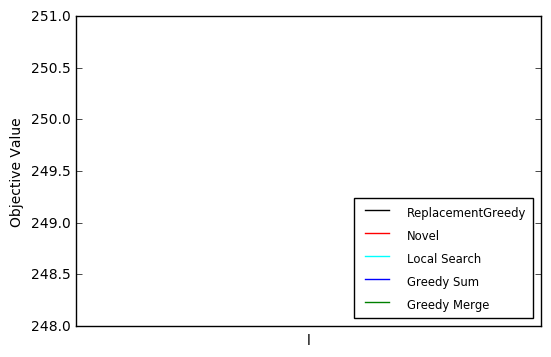

In [17]:
import matplotlib.pyplot as plt

ax = plt.subplot(111)

# http://matplotlib.org/users/text_intro.html
ax.set_xlabel('l')
ax.set_ylabel('Objective Value')

plt.ylim(248,251)
plt.xlim(0,len(novSol)-1)
labels = [l for l in range(6,30,4)]

x = [i for i in range(len(novSol))]


plt.xticks(x, labels)

plt.plot(rgSol, c = 'black', label = 'ReplacementGreedy')
plt.plot(rgSol, 'ko')

plt.plot(novSol, c = 'red', label = 'Novel')
plt.plot(novSol, 'ro')

plt.plot(lsSol, c = 'cyan', label = 'Local Search')
plt.plot(lsSol, 'co')

plt.plot(gsSol, c = 'blue', label = 'Greedy Sum')
plt.plot(gsSol, 'bo')

plt.plot(gmSol, c = 'green', label = 'Greedy Merge')
plt.plot(gmSol, 'go')

# http://matplotlib.org/1.3.0/examples/pylab_examples/legend_demo.html
legend = ax.legend(loc='lower right')

# Set the fontsize
for label in legend.get_texts():
    label.set_fontsize('small')



plt.show()

In [18]:
runtime

[]